# *Broadcasting*

Hemos visto como la vectorización es la estrategia que permite eliminar
bucles lentos. Se denomina *broadcasting* en este contexto a las reglas
que permiten aplicar la vectorización a *arrays de diferente tamaño*.

In [1]:
import numpy as np
a = np.array([0, 1, 2])
b = np.array([4, 4, 4])
a + b

array([4, 5, 6])

Supongamos ahora que queremos aplicar la suma con un escalar

In [2]:
a + 4

array([4, 5, 6])

El resultado es equivalente a extender o difundir (*broadcast*) el escalar
al tamaño completo del array. Es importante recalcar que esta extensión
no se realiza en memoria (no se crea un array nuevo) pero es un modelo para
entender lo que sucede.

Veamos que sucede si extendemos la operación a un caso bidimensional.

In [3]:
c = np.ones((3, 3))
print('c=', c)
a + c

c= [[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

En este caso, el array `a` se ha extendido por filas.


## Reglas de broadcasting

Numpy tiene unas reglas que determinan cómo se propagan los valores
cuando hay interacción entre arrays.
Se comparan las dimensiones de los dos arrays de derecha a izquierda.
Los valores son compatibles si:

 * Son iguales
 * Uno de ellos es uno
 * Uno de ellos está vacío

En caso contrario se lanza la excepción `ValueError: operands could not be broadcast together`.

Veamos algunos ejemplos.

### Ejemplo 1

In [4]:
c = np.ones((3, 3))
a + c

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

<pre> 
       c  (2d) 3 x 3
       a  (1d)     3
resultado (2d) 3 x 3
</pre>

Empezando por la derecha, la dimensión 3 es compatible. La sigiente 
es 3 para `c` y no existe para `a`. Así que en esa dimensión `a` adquiere una
dimensión 1 (1x3) y luego se replica (por filas).

### Ejemplo 2
¿Cómo lograríamos sumar por columnas en lugar de filas?. Dado que ejes se emparejan por la derecha, tendríamos que tener una distribución así:


<pre> 
       c  (2d) 3 x 3
       b  (2d) 3 x 1
resultado (2d) 3 x 3
</pre>

Sin embargo, el array `b` no puede ser 1-dimensional, dado que en numpy
los arrays 1d son siempre vectores fila.

Podemos convertir el array `a` en otro array `b` 2d, pero con una dimensión igual a 1 (vector columna o fila) usando `np.newaxis` o `reshape`

In [5]:
b = a[:, np.newaxis]
print(b.shape)
b = a.reshape((3, 1))
print(b.shape)

(3, 1)
(3, 1)


La forma con `np.newaxis` es más práctica ya permite añadir una dimensión
sin tener que saber el tamaño del array

In [6]:
a[:, np.newaxis] + c

array([[1., 1., 1.],
       [2., 2., 2.],
       [3., 3., 3.]])

Ahora ya tenemos:
<pre> 
       c  (2d) 3 x 3
       b  (2d) 3 x 1
resultado (2d) 3 x 3
</pre>

Y como se ve, el array se replica por columnas.

### Ejemplo 3

Supongamos que queremos multiplicar dos vectores de diferente dimensión

In [7]:
a = np.arange(3)
b = np.arange(4)
a * b

ValueError: operands could not be broadcast together with shapes (3,) (4,) 

Se produce un error ya que se incumplen las reglas de *broadcast*.

<pre> 
       a  (1d) 3
       b  (1d) 4
resultado error
</pre>

Para que sea posible el producto, tenemos que añadir una dimensión extra o bien
a `a` o bien a `b`. El tamaño final depende de a qué array se añada:

<pre> 
       a  (2d) 3x1
       b  (1d)   4
resultado (2d) 3x4
</pre>

y también es posible:

<pre> 
       a  (1d)   3
       b  (2d) 4x1
resultado (2d) 4x3
</pre>

Para el primer caso:

In [8]:
a[:, np.newaxis] * b

array([[0, 0, 0, 0],
       [0, 1, 2, 3],
       [0, 2, 4, 6]])

y para el segundo:

In [9]:
a * b[:, np.newaxis] 

array([[0, 0, 0],
       [0, 1, 2],
       [0, 2, 4],
       [0, 3, 6]])

### Ejemplo 4

Un ejemplo útil es la generación de funciones sobre grid.
Supongamos que queremos evaluar $f(x, y) = \cos (x + 2y) \sin(x^2 - y)$

Podemos hacer:

In [10]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
fxy = np.cos(x + 2 * y) * np.sin(x**2 - y)
print(fxy.shape)

(100,)


Sin embargo, el resultado es unidimensional, no 2d. Tanto `x` como `y`
tienen de tamaño `(100,)`, por lo que se multiplican como 1d.

Para conseguir que `fxy` sea bidimensional, tenemos que hacer `x` o `y` 
bidimensional añadiendo un eje con `np.newaxis`.

Shape: (100, 100)


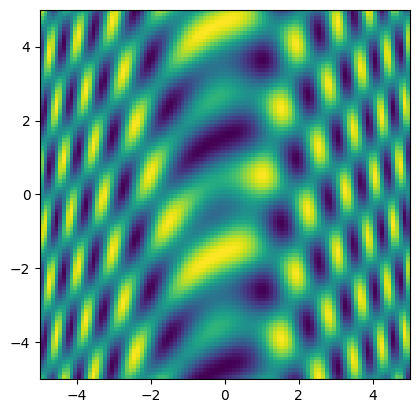

In [11]:
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)[:, np.newaxis]
fxy = np.cos(x + 2 * y) * np.sin(x**2 - y)

# Podemos pintar la función con matplotlib
import matplotlib.pyplot as plt
plt.imshow(fxy,  extent=[-5, 5, -5, 5]);
print('Shape:', fxy.shape)

### Ejemplo 5

Como último ejemplo, vamos a centrar un array tabular restando la media por 
columnas. Empezamos construyendo un array que contendrá la tabla, con
4 columnas (las características) y 100 filas (los objetos).
Rellenamos cada columna con datos aleatorios de una distribución normal 
diferente media y varianza.

In [12]:
arr = np.random.normal(loc=[10,0.1,2.3,-1.0], 
                       scale=[2.1,0.03,0.5,0.2], 
                       size=(100, 4)
                       )
# la media se calcula colapsando las filas
mean_arr = np.mean(arr, axis=0)
# dadas las dimensiones (100, 4) y (4,), podemos restar
# directamente
res = arr - mean_arr
# y la media es:
print(np.mean(res, axis=0))
# que son valores compatibles con 0

[-1.04805054e-15 -2.77555756e-19 -1.82076576e-16 -1.74305015e-16]
